In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [43]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

In [3]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
pd.set_option('display.max_columns', df.shape[1])
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
# store original dataframe
df_orig = df[:]

In [6]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [7]:
# print nr of unique values per column
for c in df.columns:
    print(c, df[c].nunique())

customerID 7043
gender 2
SeniorCitizen 2
Partner 2
Dependents 2
tenure 73
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1585
TotalCharges 6531
Churn 2


In [8]:
def get_heat_map_corr(corr_df, figsize=(10, 9), remove_cols=[], corr_method='pearson', title=None, mirrored=False):

    df_temp = corr_df
    for i in remove_cols:
        try:
            df_temp = df_temp.drop(i,axis=1)
        except:
            print(f'column {i} not found')
    
    for c in df_temp.columns:
        if df_temp[c].dtype == 'object':
            df_temp = df_temp.drop(c,axis=1)
            print(f'skipping columns [{c}] of object type')

    corr = df_temp.corr(method=corr_method)

    f, ax = plt.subplots(figsize=figsize)

    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    if title != None:
        plt.title(title)

    if mirrored == False:
        sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
    else:
        sns.heatmap(corr, annot=True, cmap=cmap)

In [9]:
# labeling columns 
label = LabelEncoder()

# encode all 'object' columns
cols_to_encode = [i for i in df.columns if df[i].dtype == 'object']
cols_to_encode

for c in cols_to_encode:
    label.fit(df[c].drop_duplicates())
    df[c] = label.transform(df[c])

df.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505,0


In [10]:
# check if nr of values didn't change after labeling
for c in df.columns:
    print(c, df[c].nunique())

customerID 7043
gender 2
SeniorCitizen 2
Partner 2
Dependents 2
tenure 73
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1585
TotalCharges 6531
Churn 2


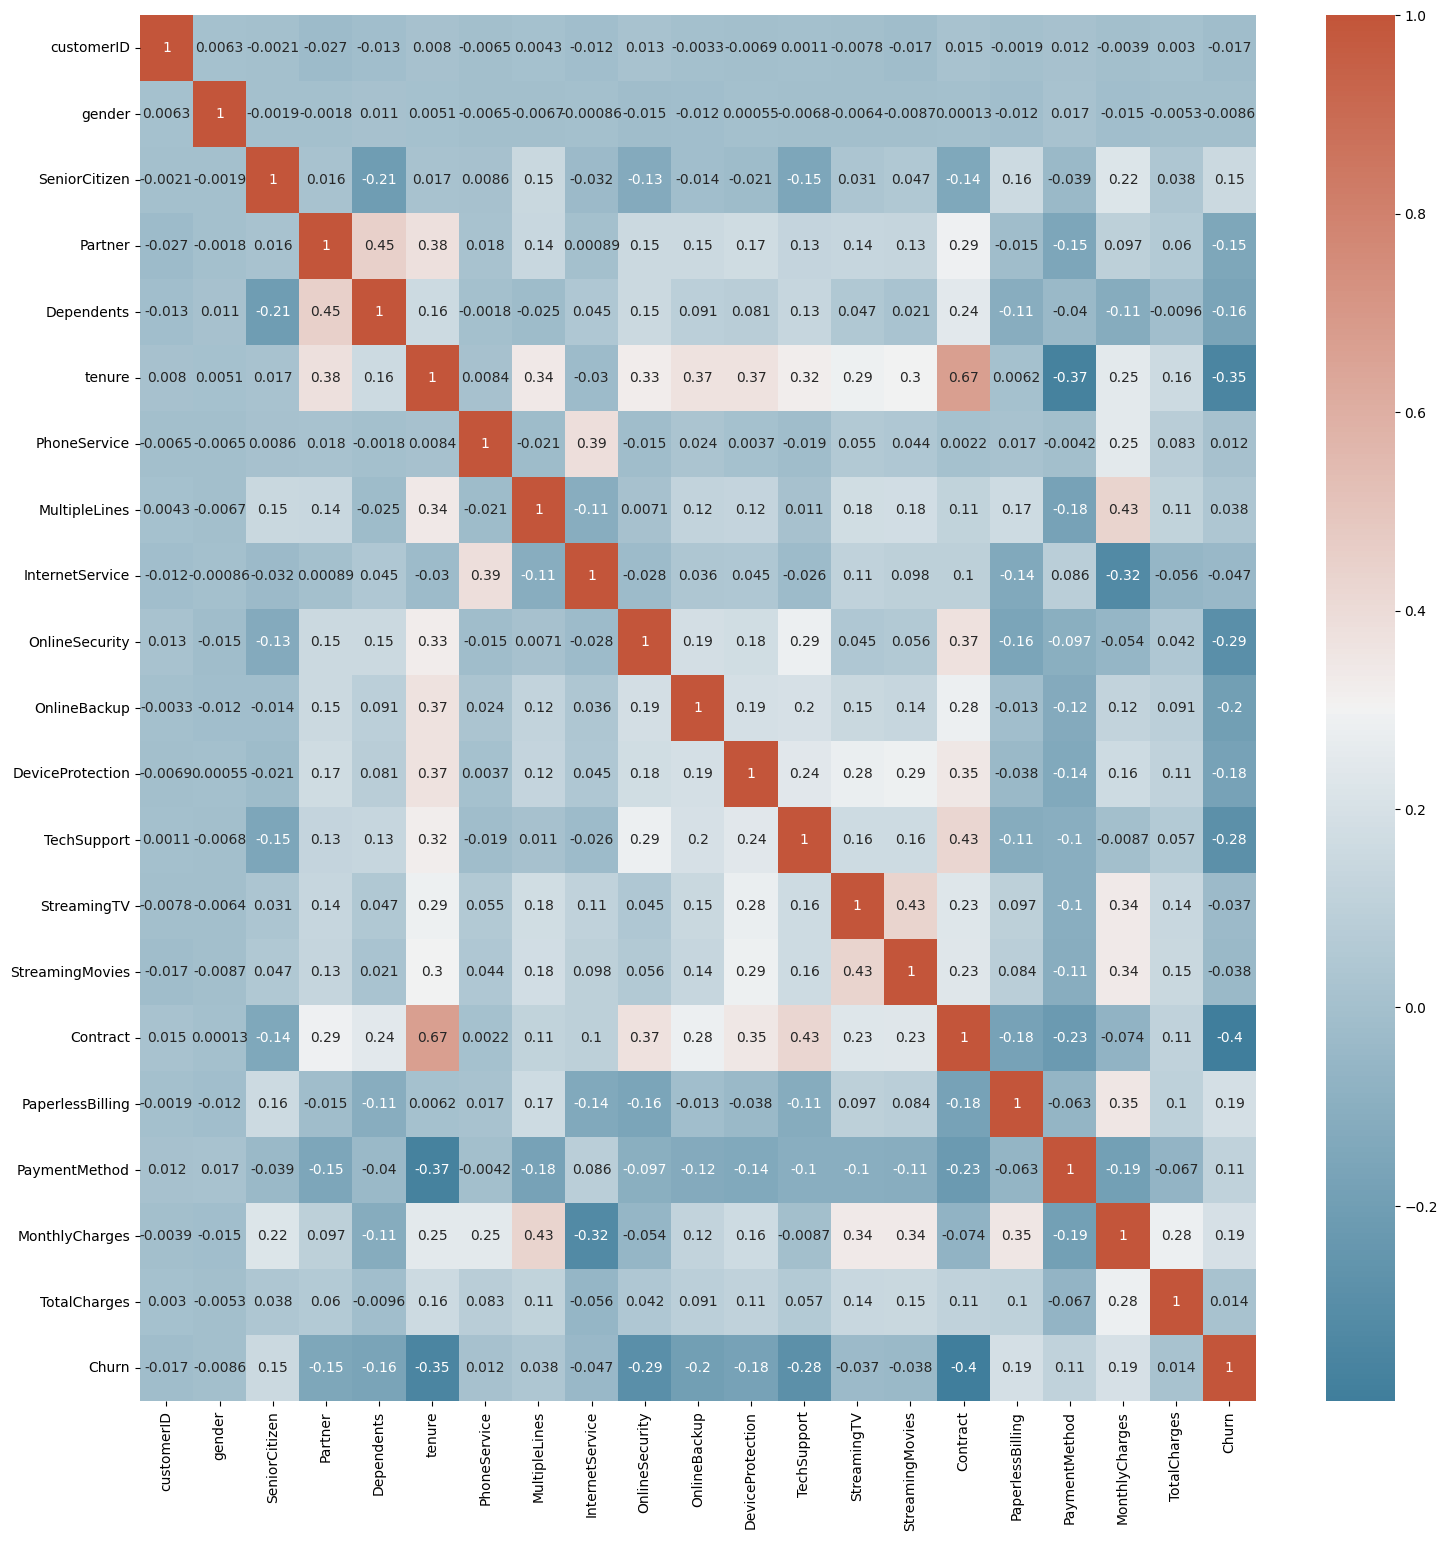

In [11]:
get_heat_map_corr(df, figsize=(18,18), mirrored=True)

In [12]:
def get_correlation(df, target_col, cols, sort=True):
    corr_dict = {}
    for i in cols:
        correlation = target_col.corr(df[i])
        corr_dict[i] = correlation

    if sort:
        corr_dict = dict(sorted(corr_dict.items(), key=lambda x: x[1], reverse=True))
    return corr_dict

In [13]:
# get sorted correlation columns to target col
cols = [i for i in df.columns]
cols.remove('customerID')
cols.remove('Churn')

corr_dir = get_correlation(df,df['Churn'], cols)
corr_dir

{'MonthlyCharges': 0.19335642223784694,
 'PaperlessBilling': 0.19182533166646773,
 'SeniorCitizen': 0.15088932817647324,
 'PaymentMethod': 0.10706200587340345,
 'MultipleLines': 0.03803688560618711,
 'TotalCharges': 0.014478977600651784,
 'PhoneService': 0.011941980029002963,
 'gender': -0.008612095078997867,
 'StreamingTV': -0.036580993373186724,
 'StreamingMovies': -0.038491628519887314,
 'InternetService': -0.04729138768314238,
 'Partner': -0.1504475449591766,
 'Dependents': -0.16422140157972498,
 'DeviceProtection': -0.1781338610668765,
 'OnlineBackup': -0.19552501409217637,
 'TechSupport': -0.28249160820465163,
 'OnlineSecurity': -0.289308996122324,
 'tenure': -0.3522286701130777,
 'Contract': -0.3967126292098425}

([<matplotlib.axis.XTick at 0x1edd52a8150>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

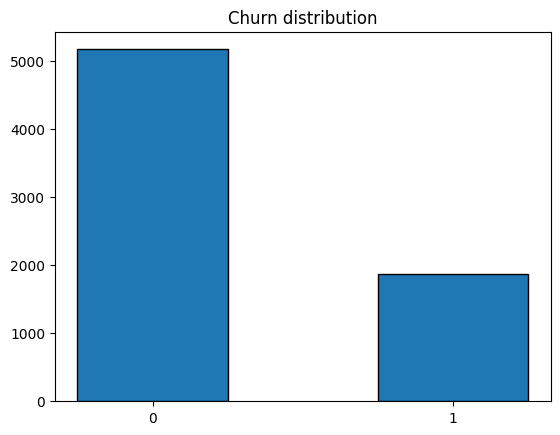

In [14]:
# plot Customers who left within the last month distibution
plt.bar(df['Churn'].value_counts().index, df['Churn'].value_counts().values, width=.5, edgecolor='black')
plt.title("Churn distribution")
plt.xticks(df['Churn'].value_counts().index)

<Axes: title={'center': 'Number of months the customer has stayed with the company'}, xlabel='customers', ylabel='nr of months'>

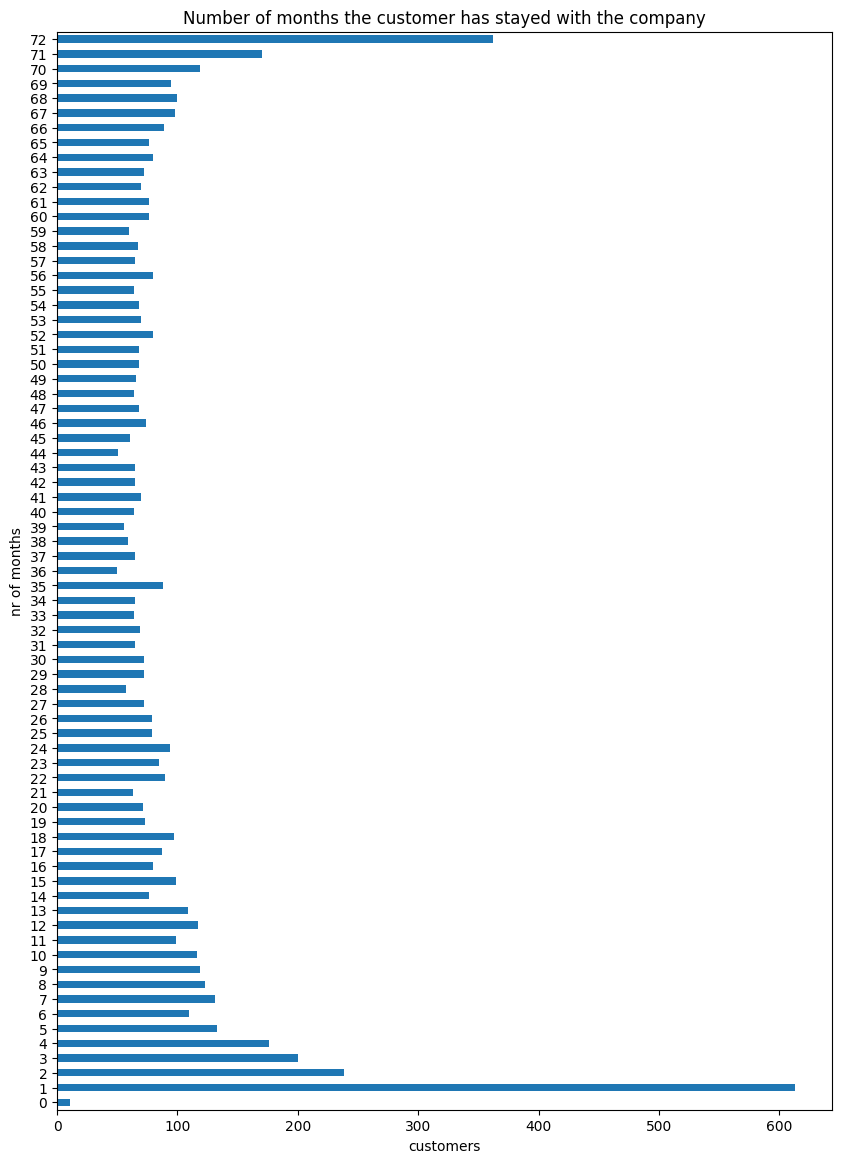

In [15]:
# plt.hist(df["tenure"].value_counts())
# plt.bar(df["tenure"].value_counts())

# plt.barh(df["tenure"].value_counts().sort_index().index, df["tenure"].value_counts().sort_index().values)

df['tenure'].value_counts().sort_index().plot(
    kind='barh', 
    figsize=(10,14),
    title="Number of months the customer has stayed with the company",
    xlabel='customers',
    ylabel='nr of months'
)

Text(0.5, 1.0, 'PaymentMethod distribution')

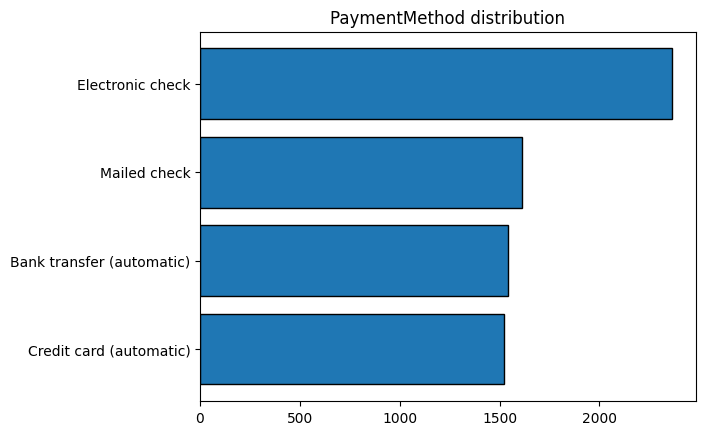

In [16]:
# plotting sorted PaymentMethod distribution
plt.barh(
    df_orig['PaymentMethod'].value_counts().sort_values().index, 
    df_orig['PaymentMethod'].value_counts().sort_values().values, 
    edgecolor='black',
)
plt.title("PaymentMethod distribution")
# df_orig['PaymentMethod'].value_counts().sort_values()

MonthlyCharges       Axes(0.125,0.11;0.352273x0.77)
TotalCharges      Axes(0.547727,0.11;0.352273x0.77)
dtype: object

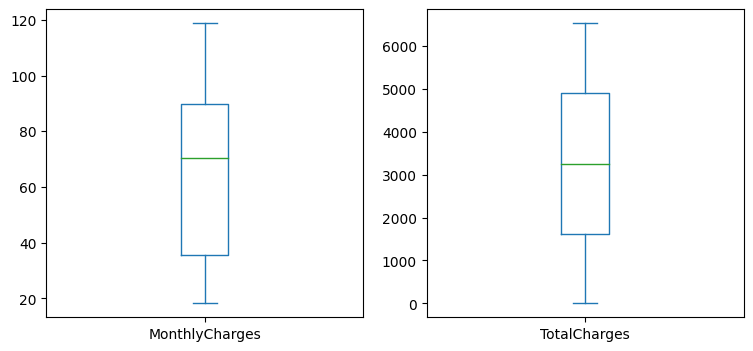

In [17]:
# outliers of 'MonthlyCharges','TotalCharges'
df[['MonthlyCharges','TotalCharges']].plot(kind='box',figsize=(9,4),subplots=True)

In [18]:
# cheking for nulls
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [19]:
# checking for duplicate 
df.duplicated().sum()
# df_orig.duplicated().sum()

0

In [20]:
# dropped targed column and 'customerID'
X=df.iloc[:,1:-1]
X.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1466


In [21]:
y=df.iloc[:,-1]
# y

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1408, 19)
(5635, 19)
(1408,)
(5635,)


In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
X_train_scaled

array([[-1.0510156 , -0.42101963,  1.03469234, ..., -1.50907905,
         1.36167288,  0.81509418],
       [-1.0510156 , -0.42101963,  1.03469234, ...,  1.31643066,
         1.35675899, -1.39587174],
       [ 0.95146067, -0.42101963,  1.03469234, ..., -1.50907905,
        -0.3237908 , -0.05460957],
       ...,
       [ 0.95146067, -0.42101963,  1.03469234, ...,  0.37459409,
        -1.42122585, -0.31182325],
       [ 0.95146067,  2.37518619, -0.96647087, ...,  0.37459409,
         1.14382383, -1.53841099],
       [ 0.95146067, -0.42101963, -0.96647087, ..., -0.56724248,
        -1.46545085,  0.34782266]])

In [51]:
clf = LogisticRegression(
    fit_intercept=True,
    C=.1,
    random_state = 100,
    verbose=5,
    )
clf.fit(X_train_scaled, y_train)    

y_pred_scaled = clf.predict(X_train_scaled)
# y_pred_scaled

# predict from test data
print(f"score on test  {clf.score(X_test_scaled,y_test)}")
print(f"score on train {clf.score(X_train_scaled,y_train)}")


score on test  0.80301685891748
score on train 0.8053977272727273


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [86]:

# print(f"mean_squared_error  {mean_squared_error(y_test.to_numpy(),y_pred_scaled)}") # lower == better
# # print( type(y_test.to_numpy()) )
# print( type(y_test.to_numpy() ))
# print( type(y_pred_scaled) )

In [26]:
# printing confusion_matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_pred, y_test)

c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([[ 107,    4],
       [4015, 1509]], dtype=int64)

In [95]:
clf = LogisticRegression(max_iter=600)
clf.fit(X_train, y_train)

print(f"score on test  {clf.score(X_test,y_test)}")
print(f"score on train {clf.score(X_train,y_train)}")

# clf.coef_

score on test  0.7975155279503106
score on train 0.7990056818181818


In [42]:
clf.predict_proba(X_test)
# clf.coef_
# clf.predict(X_test)

array([[0.37200558, 0.62799442],
       [0.88410281, 0.11589719],
       [0.99464236, 0.00535764],
       ...,
       [0.92300994, 0.07699006],
       [0.9396649 , 0.0603351 ],
       [0.45533003, 0.54466997]])

In [89]:
# print(f"r2_score             {r2_score(y_test, y_pred)}") # lower == better, how well model fits data (but not for logistic reg)
print(f"mean_squared_error   {mean_squared_error(y_test,y_pred)}") # lower == better
print(f"mean_absolute_error  {mean_absolute_error(y_test,y_pred)}") # lower == better
print(f"intercept_           {clf.intercept_}") # if positive, target increases as features increase, negative - opposite


r2_score             -2.631324093021407
mean_squared_error   0.7132209405501331
mean_absolute_error  0.7132209405501331
intercept_           [-1.67121493]


In [94]:
# plt.scatter(y_test.index, y_test)
# plt.plot(y_pred)

array([1, 1, 0, ..., 1, 1, 1])

In [31]:
# coefficent
data = {}
for indx, col_name in enumerate(X_train):
    # print(col_name, clf.coef_[indx])
    # print(col_name, indx, clf.coef_[indx])
    data[col_name] = clf.coef_[0][indx]
data = dict(sorted(data.items(), key=lambda x: x[1],reverse=True))
data

# clf.coef_[0][0]
# # clf.coef_

{'PaperlessBilling': 0.48817102657229994,
 'SeniorCitizen': 0.1743216702618407,
 'StreamingMovies': 0.13447750089238183,
 'Partner': 0.09595835205044442,
 'MultipleLines': 0.07835955017787243,
 'InternetService': 0.05362943458196865,
 'MonthlyCharges': 0.023337288276872887,
 'TotalCharges': 2.6853985759037316e-05,
 'tenure': -0.03650603243685162,
 'PaymentMethod': -0.08611321148408235,
 'DeviceProtection': -0.08896430341441618,
 'TechSupport': -0.11811523945407609,
 'StreamingTV': -0.1650847911577912,
 'OnlineBackup': -0.1694733799834615,
 'OnlineSecurity': -0.21713299045780937,
 'gender': -0.3329593591284045,
 'Dependents': -0.37995163423180944,
 'PhoneService': -0.5306388340116867,
 'Contract': -0.812563197892556}

In [ ]:
# printing confusion_matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_pred, y_test)

array([[3659,  678],
       [ 463,  835]], dtype=int64)

In [35]:
pd.DataFrame.from_dict(data, orient='index')

,0
PaperlessBilling,0.49
SeniorCitizen,0.17
StreamingMovies,0.13
Partner,0.10
MultipleLines,0.08
InternetService,0.05
MonthlyCharges,0.02
TotalCharges,0.00
tenure,-0.04
PaymentMethod,-0.09
